### BASE DE DATOS DE LA EVOLUCIÓN DEL CLIMA

---

##### Trabajo practico II - Analisis predictivo avanzado - ITBA
##### *Entrega final*


### PASO 1: Importar librerias

In [ ]:
import pandas as pd
import requests
from datetime import datetime
import warnings
import openpyxl
import datetime
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, auc, RocCurveDisplay
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.pipeline import FeatureUnion, Pipeline
import xgboost as xgb
import matplotlib.colors as mcolors
from pandas.plotting import scatter_matrix
import geopy
import geopy.distance as distance
import shapely.wkt
from shapely.geometry import LineString, Point
import geopandas as gpd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.io as pio
import statsmodels.api as sm


### PASO 2: abrir el dataset

In [ ]:
# CARGAMOS EL DATASET #
df = pd.read_csv('ClimateChange.csv')

In [ ]:
df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W
...,...,...,...,...,...,...,...
176751,1862-08-01,25.095,2.556,Peking,China,39.38N,116.53E
176752,1862-09-01,19.002,1.655,Peking,China,39.38N,116.53E
176753,1862-10-01,12.051,1.816,Peking,China,39.38N,116.53E
176754,1862-11-01,1.468,2.047,Peking,China,39.38N,116.53E


In [ ]:
# ESTANDARIZAMOS LAS FECHAS #
import pandas as pd
from datetime import datetime

from datetime import datetime

def separar_fecha(df, columna):
    # Itera sobre las filas del DataFrame
    for index, fila in df.iterrows():
        fecha = fila[columna]

        if "-" in fecha:
            # Convierte la cadena de fecha al objeto datetime
            fecha_obj = datetime.strptime(fecha, '%Y-%d-%m')
        else:
            # Convierte la cadena de fecha al objeto datetime para el caso sin "-"
            fecha_obj = datetime.strptime(fecha, '%d/%m/%Y')

        # Agrega columnas al DataFrame para día, mes, año y fecha formateada
        df.at[index, "dia"] = int(fecha_obj.day)
        df.at[index, "mes"] = int(fecha_obj.month)
        df.at[index, "anio"] = int(fecha_obj.year)
        df.at[index, "dt"] = fecha_obj.strftime('%d/%m/%Y')

    return df


# CONVERTIR LAS COORDENADAS #
def convertir_coordenadas(coordenada):
    deg = float(coordenada[:-1])
    direction = coordenada[-1]
    decimal_coord = deg if direction.upper() in ['N', 'E'] else -deg if direction.upper() in ['S', 'W'] else None
    return decimal_coord

In [ ]:
df = separar_fecha(df, "dt")
df['Latitude'] = df['Latitude'].apply(convertir_coordenadas)
df['Longitude'] = df['Longitude'].apply(convertir_coordenadas)

In [ ]:
df['dt'] = pd.to_datetime(df['dt'])

df = df[df['dt'].dt.year >= 2000]

In [ ]:
# VALORES DE LOS MESES #
valores_mes_unicos = df['mes'].unique()
print(valores_mes_unicos)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


### PASO 3: eda - analisis general de la base

##### Primer aproach

In [ ]:
num_filas, num_columnas = df.shape
print("Cantidad de filas:", num_filas)
print("Cantidad de columnas:", num_columnas)

Cantidad de filas: 16500
Cantidad de columnas: 10


In [ ]:
columnas_categoricas= df.select_dtypes(include=['object'])

columnas_numericas = df.select_dtypes(exclude=['object'])

print("Tipos de columnas:")
print("Categoricas:",columnas_categoricas.columns)
print("Numericas",columnas_numericas.columns)

Tipos de columnas:
Categoricas: Index(['City', 'Country'], dtype='object')
Numericas Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Latitude',
       'Longitude', 'mes', 'dia', 'anio'],
      dtype='object')


##### Columnas categoricas

In [ ]:
# VALORES UNICOS EN COLUMNAS CATEGORICAS #
cantidad_valores_unicos = columnas_categoricas.nunique()
cantidad_valores_unicos

City       100
Country     49
dtype: int64

In [ ]:
# VALORES NULOS #
cantidad_nulos_categoricas = columnas_categoricas.isnull().sum()
cantidad_nulos_categoricas

City       0
Country    0
dtype: int64

##### Columnas numericas

In [ ]:
# VALORES NULOS #
cantidad_nulos_numericas= columnas_numericas.isnull().sum()
cantidad_nulos_numericas

dt                                0
AverageTemperature               93
AverageTemperatureUncertainty    93
Latitude                          0
Longitude                         0
dia                               0
mes                               0
anio                              0
dtype: int64

In [ ]:
# OUTLIERS #
if 'dt' in columnas_numericas.columns:
    columnas_numericas = columnas_numericas.drop(columns=['dt'])

stats = columnas_numericas.describe()
Q1 = stats.loc['25%']
Q3 = stats.loc['75%']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Outliers de cada variable:")
outliers = ((columnas_numericas < lower_bound) | (columnas_numericas > upper_bound))
outlier_counts = outliers.sum()
outlier_counts

Outliers de cada variable:


AverageTemperature               421
AverageTemperatureUncertainty    922
Latitude                         165
Longitude                          0
dia                                0
mes                                0
anio                               0
dtype: int64

In [ ]:
# ESTADISTICOS DESCRIPTIVOS #
estadisticas_descriptivas = columnas_numericas.describe()
estadisticas_descriptivas

,AverageTemperature,AverageTemperatureUncertainty,Latitude,Longitude,dia,mes,anio
count,16406.000000,16406.000000,16499.000000,16499.000000,16499.000000,16499.0,16499.000000
mean,19.732416,0.385153,20.061575,45.464851,6.418510,1.0,2006.382205
std,9.579745,0.233586,22.370078,65.805309,3.427241,0.0,3.970233
min,-23.495000,0.056000,-37.780000,-118.700000,1.000000,1.0,2000.000000
25%,14.869500,0.243000,7.230000,8.220000,3.000000,1.0,2003.000000
50%,22.118500,0.330000,24.920000,46.110000,6.000000,1.0,2006.000000
75%,26.999500,0.454000,36.170000,105.105000,9.000000,1.0,2010.000000
max,38.283000,3.963000,60.270000,151.780000,12.000000,1.0,2013.000000


##### Imputacion de missings

In [ ]:
df['dt'] = pd.to_datetime(df['dt'])
city_monthly_mean = df.groupby(['City', df['dt'].dt.month])['AverageTemperature'].mean()
city_monthly_mean1 = df.groupby(['City', df['dt'].dt.month])['AverageTemperatureUncertainty'].mean()

for index, row in df.iterrows():
    city = row['City']
    month = row['dt'].month
    if pd.isnull(row['AverageTemperature']):
        mean_value = city_monthly_mean.get((city, month))
        df.at[index, 'AverageTemperature'] = mean_value
    if pd.isnull(row['AverageTemperatureUncertainty']):
        mean_value1 = city_monthly_mean1.get((city, month))
        df.at[index, 'AverageTemperatureUncertainty'] = mean_value1

In [ ]:
null_counts = df.isnull().sum()
print(null_counts)

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
mes                              0
dia                              0
anio                             0
dtype: int64


### PASO 4: eda - análisis gráfico

#### Variables categoricas

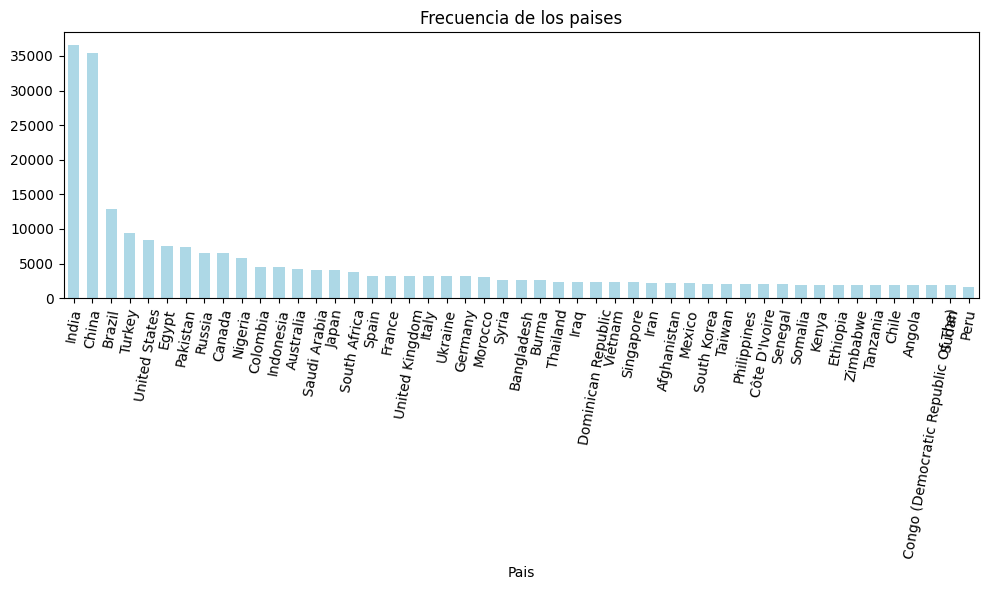

In [ ]:
# GRAFICO DE FRECUENCIA DE LOS PAISES #
frecuencia_paises = df['Country'].value_counts()
plt.figure(figsize=(10, 6))
frecuencia_paises.plot(kind='bar', color='#ADD8E6', width=0.6)
plt.title('Frecuencia de los paises')
plt.xlabel('Pais')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

#### Variables numericas

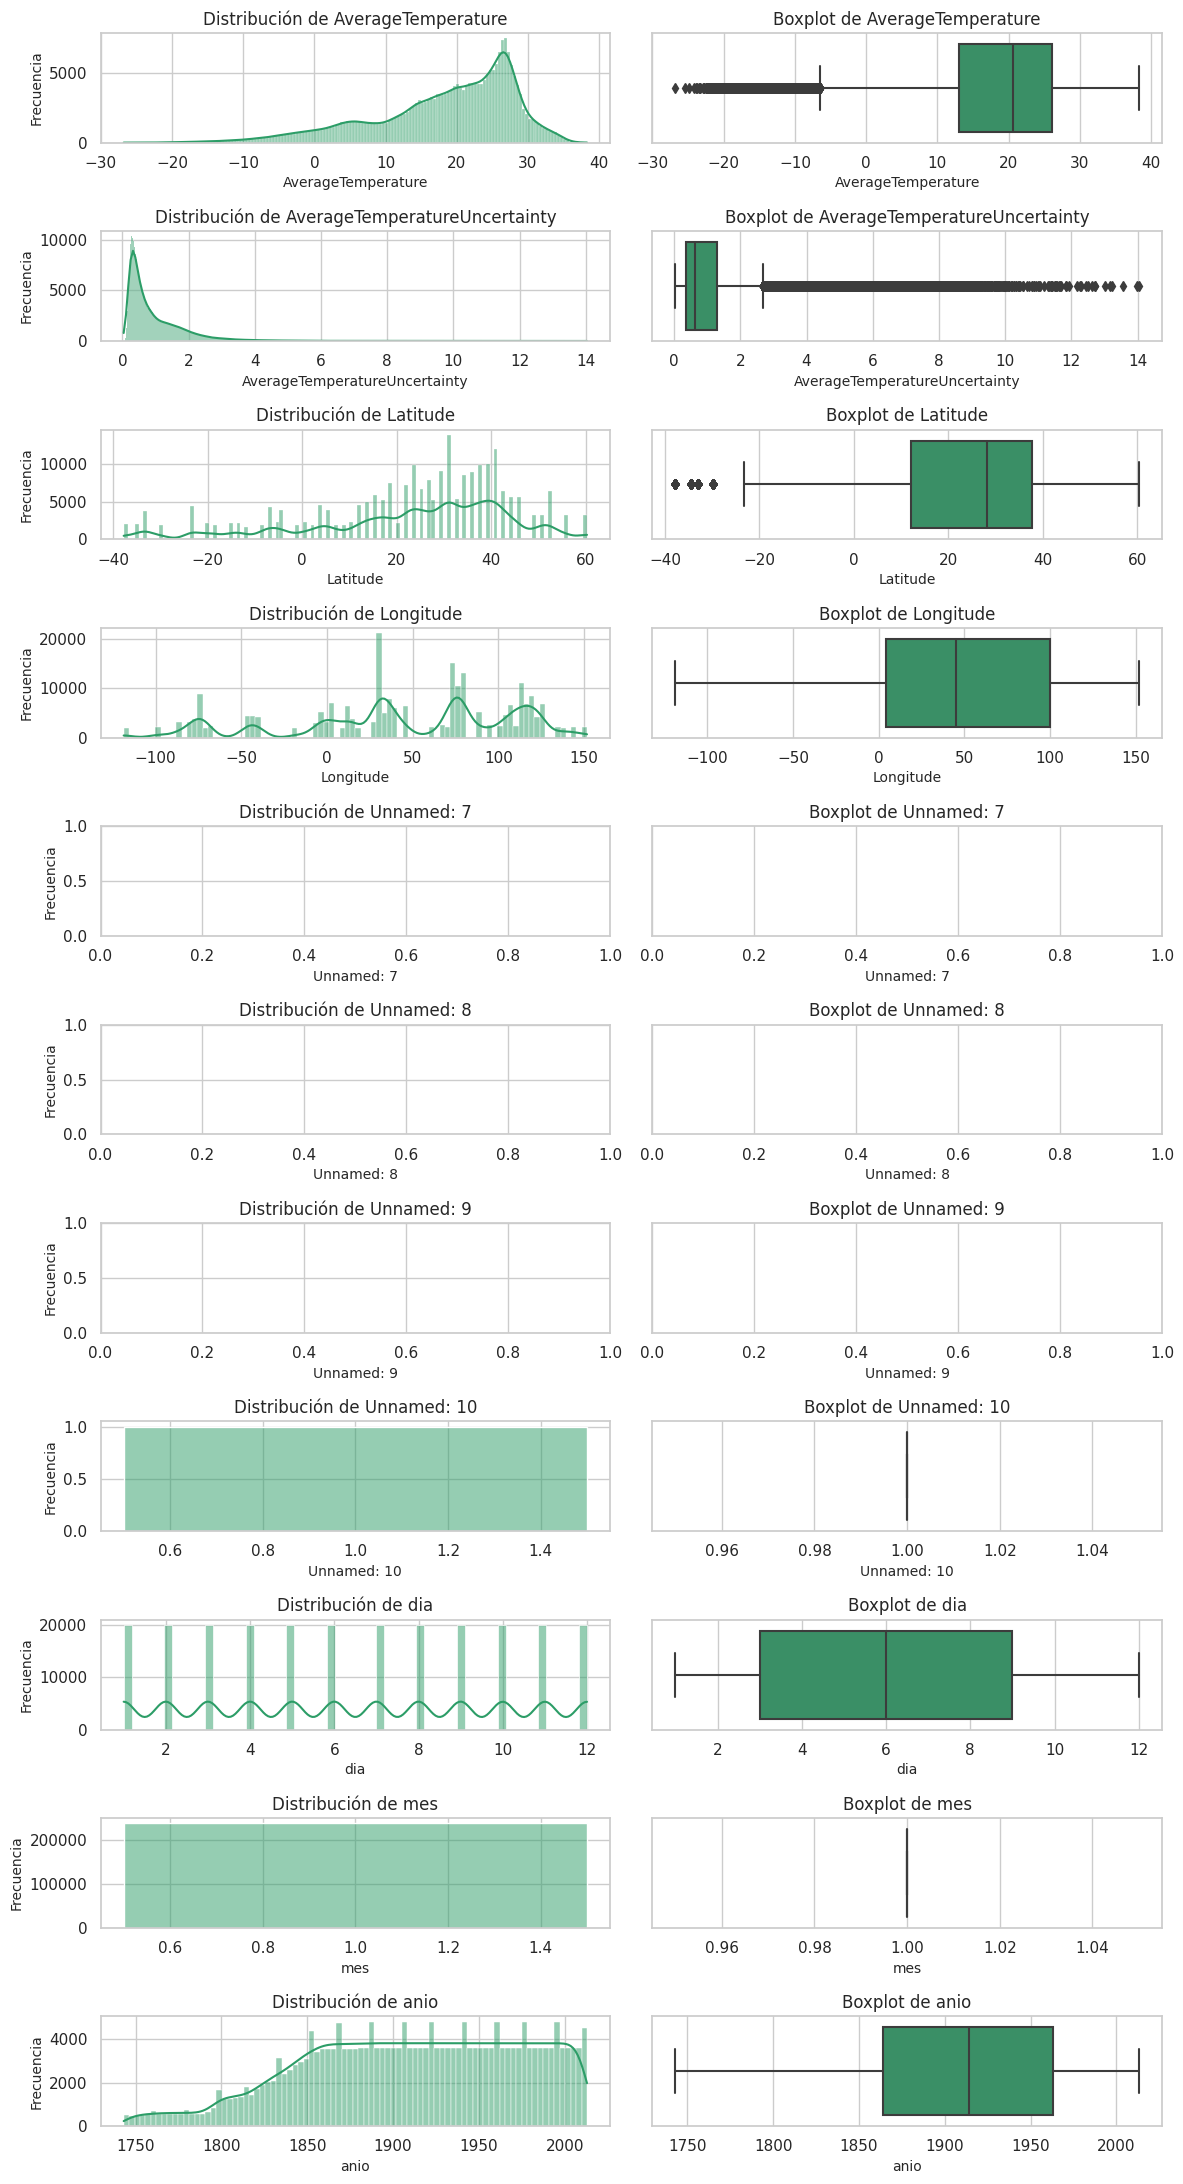

In [ ]:
sns.set(style="whitegrid", palette="deep")

# Crear subplots para los gráficos
fig, axes = plt.subplots(nrows=len(columnas_numericas.columns), ncols=2, figsize=(12, 2 * len(columnas_numericas.columns)))

# Iterar a través de las columnas numéricas
for i, columna in enumerate(columnas_numericas.columns):
    # Gráfico de distribución
    sns.histplot(data=df, x=columna, color='#2C9D67', kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribución de {columna}', fontsize=12)
    axes[i, 0].set_xlabel(columna, fontsize=10)
    axes[i, 0].set_ylabel('Frecuencia', fontsize=10)

    # Boxplot
    sns.boxplot(data=df, x=columna, color='#2C9D67', ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {columna}', fontsize=12)
    axes[i, 1].set_xlabel(columna, fontsize=10)

# Ajustar la disposición de los gráficos
plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:97: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:102: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/misc.py:92: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


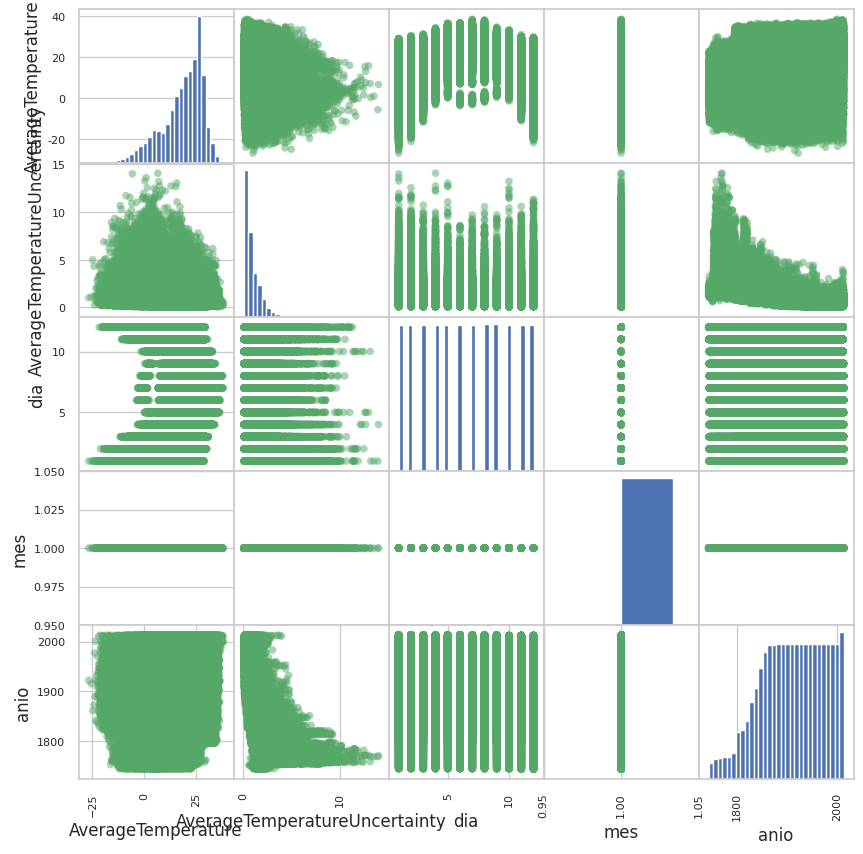

In [ ]:
bm = df.columns.isin(['AverageTemperature', 'AverageTemperatureUncertainty','dia', 'mes', 'anio'])
sc = df.columns[bm]
data = df[sc]

# Aumenta la separación entre los ejes X e Y y ajusta el tamaño de los puntos
scatter_matrix(data, alpha=0.5, figsize=(10, 10),
               marker='o', hist_kwds={'bins': 30}, s=30,
               range_padding=0.15, cmap=plt.cm.brg, diagonal='hist', color="g")

plt.show()

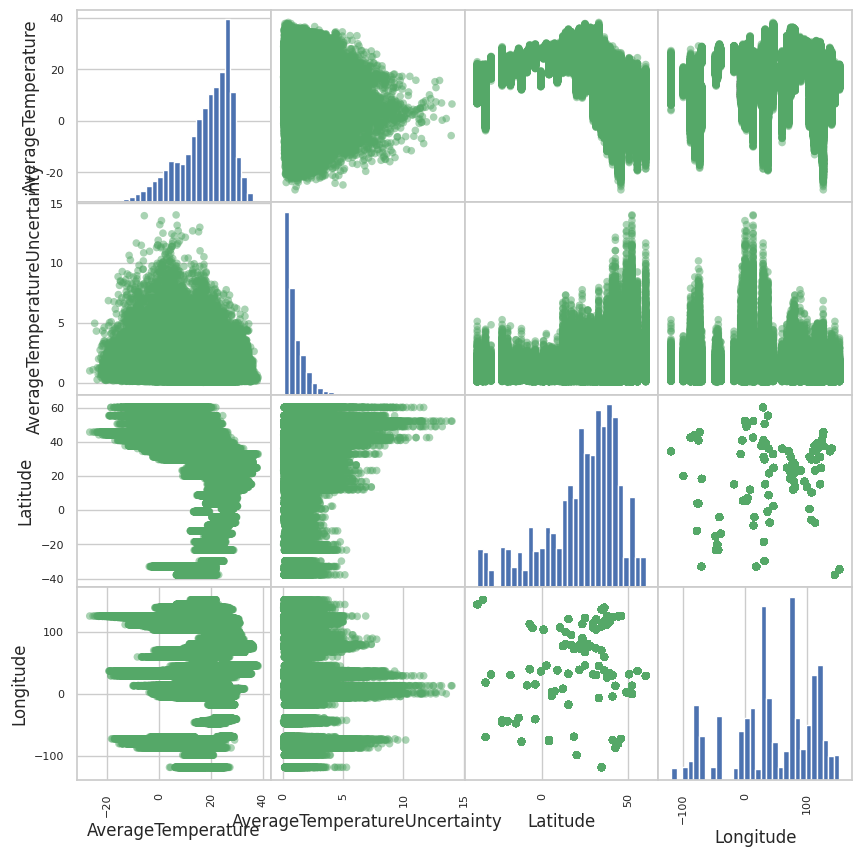

In [ ]:
bm = df.columns.isin(['AverageTemperature', 'AverageTemperatureUncertainty', 'Latitude',
       'Longitude'])
sc = df.columns[bm]
data = df[sc]

# Aumenta la separación entre los ejes X e Y y ajusta el tamaño de los puntos
scatter_matrix(data, alpha=0.5, figsize=(10, 10),
               marker='o', hist_kwds={'bins': 30}, s=30,
               range_padding=0.15, cmap=plt.cm.brg, diagonal='hist', color="g")

plt.show()

### PASO 5: GIS

#### Graficos generales

In [ ]:
# LISTA DE PAISES DE NUESTRO DF #
paises_unicos = df['Country'].unique().tolist()

# DATASET CON TODOS LOS PAISES (NATIVO) #
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# DF CON LAS CIUDADES #
df_ciudad = df[['Country', 'City', 'Latitude', 'Longitude']]
geo_ciudad=gpd.GeoDataFrame(df_ciudad,geometry=gpd.points_from_xy(df_ciudad.Longitude, df_ciudad.Latitude))

# DATOS DE LOS PAISES QUE TENEMOS #
geo_nuestro = world[world['name'].isin(paises_unicos)]

<ipython-input-99-c6442e62eae0>:5: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



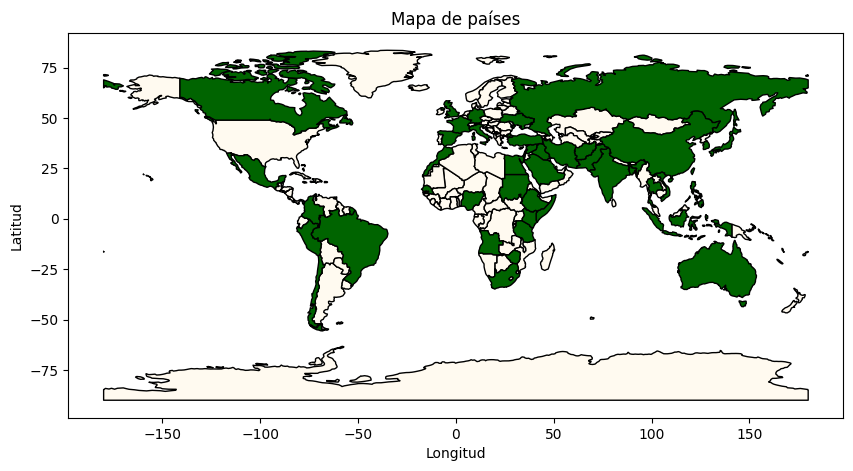

In [ ]:
# MAPA MUNDIAL #
# EN VERDE LOS PAISES QUE ESTAN EN NUESTRO DATASET
# EN BLANCO LOS PAISES QUE NO ESTAN
world['in_geo_nuestro'] = world['name'].isin(paises_unicos)
fig, ax = plt.subplots(figsize=(10, 8))
world[world['in_geo_nuestro'] == False].plot(ax=ax, color='#FFFAF0', edgecolor='black')
world[world['in_geo_nuestro'] == True].plot(ax=ax, color='#006400', edgecolor='black')
plt.title('Mapa de países')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
world.drop('in_geo_nuestro', axis=1, inplace=True)
plt.show()

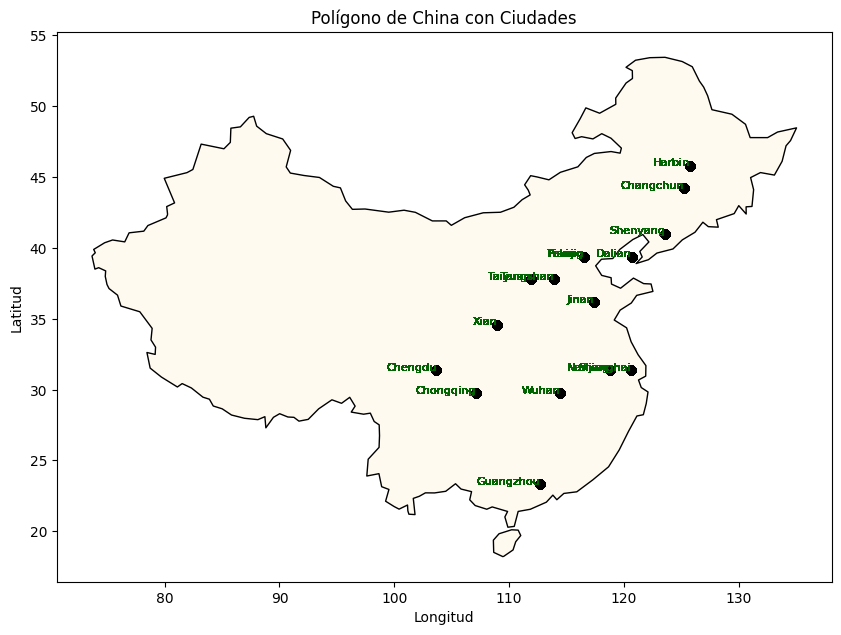

In [ ]:
# MAPA DE LOS PAISES
def plot_country_cities(country_name, df, world_data):
    ciudades_pais = df[df['Country'] == country_name]
    geo_pais = world_data[world_data['name'] == country_name]
    fig, ax = plt.subplots(figsize=(10, 8))
    geo_pais.plot(ax=ax, color='#FFFAF0', edgecolor='black')
    for x, y, label in zip(ciudades_pais['Longitude'], ciudades_pais['Latitude'], ciudades_pais['City']):
        ax.text(x, y, label, fontsize=8, ha='right', color="#006400")
        ax.plot(x, y, 'ko')
    plt.title(f'Polígono de {country_name} con Ciudades')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.show()

# Seleccionar el pais que se desea plotear
plot_country_cities('China', geo_ciudad, world)

#### Grafico interactivo

In [ ]:
# 1. Calcula la temperatura promedio por país, año y mes
df['temp_promedio_pais'] = df.groupby(['Country', 'anio', 'mes'])['AverageTemperature'].transform('mean')

# 2. Achicar un poco el df
selected_columns = ['Country', 'anio', 'mes', 'temp_promedio_pais']
df_graficos = df[selected_columns]

# 3. Traer el json del world map
import json
world_json = json.load(open("countries.geo.json","r"))

# 4. Se agrega un id al df para identificar a los paises
world_id_map = {}
if "features" in world_json:
    for feature in world_json["features"]:
        properties = feature.get("properties", {})
        feature_id = properties.get("name")

        if feature_id:
            feature["id"] = feature_id
            world_id_map[feature_id] = feature["id"]
        else:
            print("Name not found in properties:", feature)
else:
    print("Key 'features' not found in world_json")
df_graficos["id"] = df_graficos["Country"].apply(lambda x: world_id_map.get(x, "Unknown"))

# 5. Graficar el Chloropleth map
anio = 2002
mes= 6
df_graficos_especifico = df_graficos[(df_graficos["anio"] == anio) & (df_graficos["mes"] == mes)]

pio.renderers.default = None
fig = px.choropleth(df_graficos_especifico, locations = "id", geojson = world_json, color = 'temp_promedio_pais')

In [ ]:
fig.show(renderer="colab")

In [ ]:
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px

# Supongamos que ya tienes el DataFrame df_graficos creado

# 1. Crear la aplicación de Dash
app = dash.Dash(__name__)

# 2. Lista de años y meses
lista_años = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
lista_meses = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# 3. Diseño de la interfaz de la aplicación
app.layout = html.Div([
    html.H1("Choropleth Map con Dash"),

    # Dropdown para seleccionar el año
    dcc.Dropdown(
        id='dropdown-año',
        options=[{'label': str(año), 'value': año} for año in lista_años],
        value=lista_años[0],  # Valor predeterminado
        style={'width': '50%'}
    ),

    # Slider para seleccionar el mes
    dcc.Slider(
        id='slider-mes',
        min=min(lista_meses),
        max=max(lista_meses),
        step=1,
        marks={mes: str(mes) for mes in lista_meses},
        value=lista_meses[0],  # Valor predeterminado
    ),

    # Gráfico Choropleth
    dcc.Graph(id='choropleth-map')
])

# 4. Actualizar el gráfico según las selecciones del usuario
@app.callback(
    Output('choropleth-map', 'figure'),
    [Input('dropdown-año', 'value'),
     Input('slider-mes', 'value')]
)
def update_choropleth_map(selected_año, selected_mes):
    df_graficos_especifico = df_graficos[(df_graficos["anio"] == selected_año) & (df_graficos["mes"] == selected_mes)]
    fig = px.choropleth(df_graficos_especifico, locations="id", geojson=world_json, color='temp_promedio_pais')
    return fig

# Ejecutar la aplicación
if __name__ == '__main__':
    app.run_server(debug=True)


### PASO 6: Experimentacion de series de tiempo (experimentamos con china)

In [ ]:
dfnuevo = df[df['Country'] == 'Brazil']
dfnuevo['anio_mes'] = dfnuevo['dt'].dt.strftime('%Y-%m')
dfmundo = dfnuevo.groupby('anio_mes')['AverageTemperature'].mean().reset_index()
dfmundo['anio_mes'] = pd.to_datetime(dfmundo['anio_mes'])
dfmundo = dfmundo.set_index('anio_mes')
y = dfmundo['AverageTemperature'].resample('MS').mean()

<ipython-input-17-2b67397bdef5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnuevo['anio_mes'] = dfnuevo['dt'].dt.strftime('%Y-%m')


In [ ]:
y

Series([], Freq: MS, Name: AverageTemperature, dtype: float64)

#### Graficos

<Figure size 2000x2000 with 0 Axes>

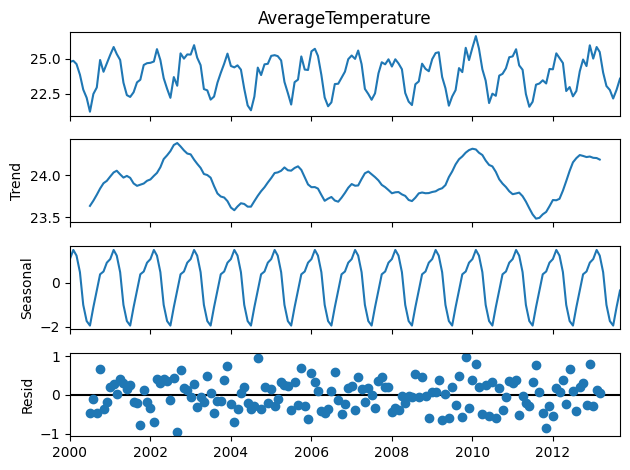

In [ ]:
plt.figure(figsize=(20,20))
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

<Figure size 1000x300 with 0 Axes>

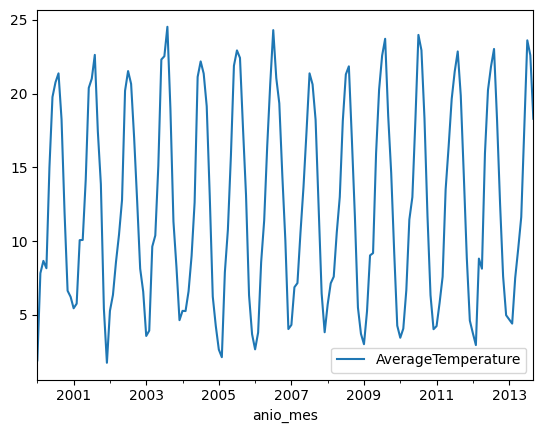

In [ ]:
plt.figure(figsize=(10,3)); dfmundo.plot(); plt.show()

#### Se realiza la division en train y test

Para el test, se tomaron los ultimos 3 años. Luego, se verifico ue los últimos meses de train no sean consecutivos a los meses de test.

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(dfmundo, test_size=36, random_state=42, shuffle=False)

In [ ]:
df_test.head(2)

,AverageTemperature,timeIndex,timeIndex_sq,log_temperature,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,model_log_est,back_LogEstTrend,QuadraticTrend
anio_mes,,,,,,,,,,,,,,,,,,,,
2010-10-01,23.914,129,16641,3.174464,Oct,0,0,0,0,0,0,0,0,0,0,1,0,3.195962,24.433671,23.864179
2010-11-01,24.310,130,16900,3.190888,Nov,0,0,0,0,0,0,0,0,0,1,0,0,3.204141,24.634332,23.862851


In [ ]:
df_train.tail(2)

#### Random walk

Se agregó una columna que almacene el valor de la tempreatura del dia anterior, para esto, el primer mes se almacena con su misma temperatura

In [ ]:
df_train["RandomWalk"] = df_train.AverageTemperature.shift()

# La primera observación nos va a quedar en nan, la reemplazamos por el valor siguente:
df_train["RandomWalk"].fillna(method='bfill', inplace=True)
df_train.head(3)

,AverageTemperature,RandomWalk
anio_mes,,
2000-01-01,24.758667,24.758667
2000-02-01,24.839833,24.758667
2000-03-01,24.607167,24.839833


Se grafica la temperatura diaria promedio y el random walk (la temperatura promedio del dia anterior)

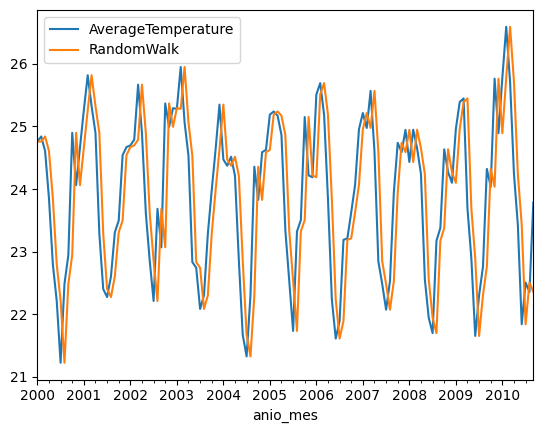

In [ ]:
df_train.plot(kind="line", y = ["AverageTemperature", "RandomWalk"]);

En el Random Walk la predicción se basa en el valor anterior, por eso para la predicción de los 3 años de test se tomará el ultimo valor de train

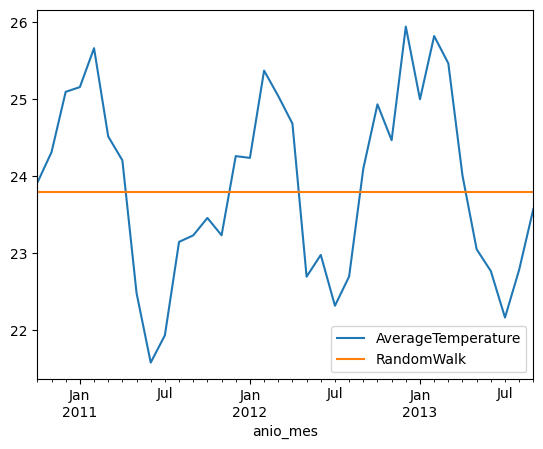

In [ ]:
df_test["RandomWalk"] = pd.Series(df_train["AverageTemperature"][-1], index=df_test.index)
df_test.plot(kind="line", y = ["AverageTemperature", "RandomWalk"]);

In [ ]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [ ]:
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Random Walk"
df_Results.loc[0, "RMSE"] = RMSE(df_test.RandomWalk, df_test.AverageTemperature)
df_Results

AttributeError: ignored

#### Modelo de tendencia cuadratica

Para este método es necesario agregar el índice según el valor aniomes y ese índice al cuadrado

In [ ]:
dfmundo["timeIndex"] = pd.Series(np.arange(len(dfmundo['AverageTemperature'])), index=dfmundo.index)
dfmundo.timeIndex.head(3)

anio_mes
2000-01-01    0
2000-02-01    1
2000-03-01    2
Name: timeIndex, dtype: int64

In [ ]:
dfmundo["timeIndex_sq"] = dfmundo["timeIndex"]**2
dfmundo.timeIndex_sq.head(3)

anio_mes
2000-01-01    0
2000-02-01    1
2000-03-01    4
Name: timeIndex_sq, dtype: int64

In [ ]:
df_train, df_test = train_test_split(dfmundo, test_size=36, random_state=42, shuffle=False)

##### Realizamos un modelo cuadratico

In [ ]:
import statsmodels.formula.api as smf
model_quadratic = smf.ols('AverageTemperature ~ timeIndex + timeIndex_sq', data = df_train).fit()

In [ ]:
df_train["QuadraticTrend"] = model_quadratic.predict(df_train[["timeIndex","timeIndex_sq"]])
df_test["QuadraticTrend"] = model_quadratic.predict(df_test[["timeIndex","timeIndex_sq"]])

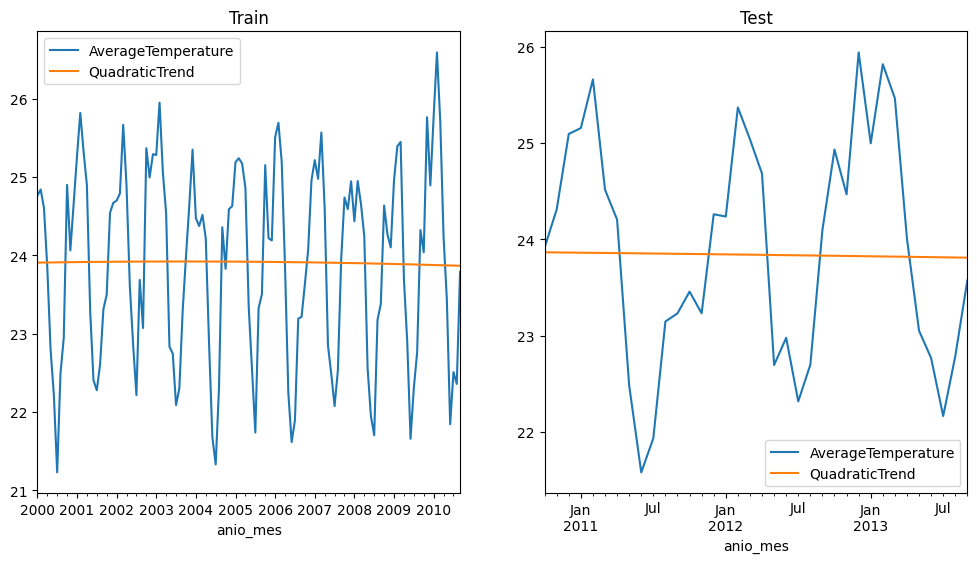

In [ ]:
fig, axes = plt.subplots(1, 2,figsize=(12,6))
df_train.plot(kind = "line", y = ["AverageTemperature","QuadraticTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["AverageTemperature","QuadraticTrend"],ax=axes[1],title='Test');
plt.show()

In [ ]:
model_RMSE = RMSE(df_test.QuadraticTrend, df_test.AverageTemperature)
df_Results.loc[3, "Model"] = "QuadraticTrend"
df_Results.loc[3, "RMSE"] = model_RMSE
AIC = model_quadratic.aic
df_Results.loc[3, "AIC"] = AIC

df_Results.head()

,Model,RMSE,AIC
0,Random Walk,1.177686,NaN
3,QuadraticTrend,1.173284,427.277047


#### Transformación logarítmica + estacionalidad mensual

> Indented block



In [ ]:
# Volvemos a hacer la division de train y test ya que agregamos nuevas columnas de índice #
df_train, df_test = train_test_split(dfmundo, test_size=36, random_state=42, shuffle=False)

In [ ]:
# Aplicamos logaritmo a los datos para reducir la variabilidad #
df_train['log_temperature'] = np.log(df_train['AverageTemperature'])
df_test['log_temperature'] = np.log(df_test['AverageTemperature'])

In [ ]:
# Creamos una dummy por cada mes, para poder captar la estacionalidad #
df_train['month'] = [d.strftime('%b') for d in df_train.index]
df_test['month']  = [d.strftime('%b') for d in df_test.index]
dummies_mes_train = pd.get_dummies(df_train['month'])
dummies_mes_test = pd.get_dummies(df_test['month'])
df_train = df_train.join(dummies_mes_train)
df_test = df_test.join(dummies_mes_test)

#### Modelo de regresión lineal con logaritmo y el factor estacional

In [ ]:
model_log_est = smf.ols('log_temperature ~ timeIndex + Apr + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep',\
                          data = df_train).fit()

In [ ]:
df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex","Apr","Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May","Nov", "Oct", "Sep"]])

df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex","Apr","Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May","Nov", "Oct", "Sep"]])

In [ ]:
# SE DEVUELVE LOS DATOS PREDICHOS DE TEMPERATURA A SU ESTADO ORIGINAL,
# APLICANDO LA FUNCION EXPONENCIAL #
df_train['back_LogEstTrend'] = np.exp(df_train['model_log_est'])
df_test['back_LogEstTrend'] = np.exp(df_test['model_log_est'])

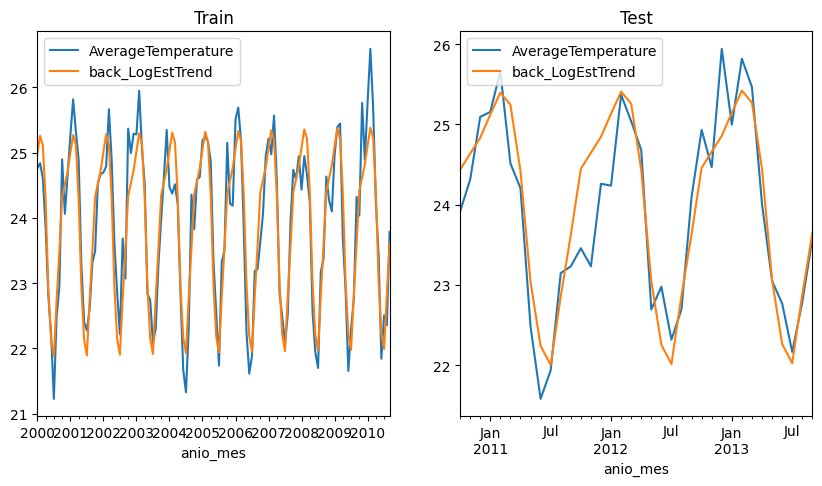

In [ ]:
# Se grafican las predicciones vs los valores originales
fig, axes = plt.subplots(1, 2,figsize=(10,5))
df_train.plot(kind = "line", y = ["AverageTemperature","back_LogEstTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["AverageTemperature","back_LogEstTrend"],ax=axes[1],title='Test');
plt.show()

In [ ]:
# Calculamos el RMSE y lo comparamos con el del Random Walk
model_RMSE = RMSE(df_test.back_LogEstTrend, df_test.AverageTemperature)
df_Results.loc[5, "Model"] = "back_LogEstTrend"
df_Results.loc[5, "RMSE"] = model_RMSE
AIC= model_log_est.aic
df_Results.loc[5, "AIC"] = AIC

df_Results


,Model,RMSE,AIC
0,Random Walk,1.177686,NaN
3,QuadraticTrend,1.173284,427.277047
5,back_LogEstTrend,0.512166,-628.636797


#### Modelo ARIMA

In [ ]:
# Creamos un nuevo dataframe que solo tenga la temperatura promedio mensual #
dfmundoSERIES= dfmundo.iloc[:, 0]
dfmundoSERIES

anio_mes
2000-01-01    24.758667
2000-02-01    24.839833
2000-03-01    24.607167
2000-04-01    23.853000
2000-05-01    22.798833
                ...    
2013-05-01    23.049500
2013-06-01    22.766667
2013-07-01    22.163833
2013-08-01    22.784667
2013-09-01    23.572872
Name: AverageTemperature, Length: 165, dtype: float64

##### Grafico de la serie

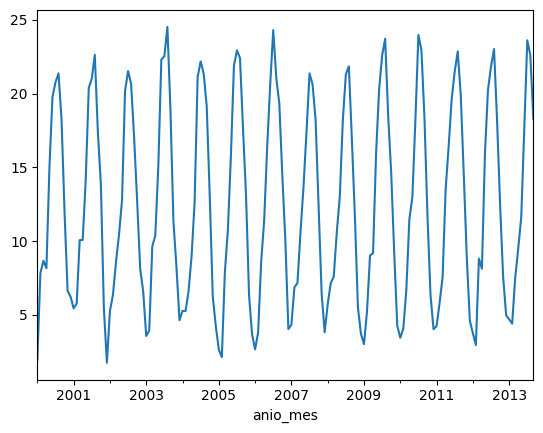

In [ ]:
from matplotlib import pyplot
dfmundoSERIES.plot()
pyplot.show()

##### Grafico de los lags ACF

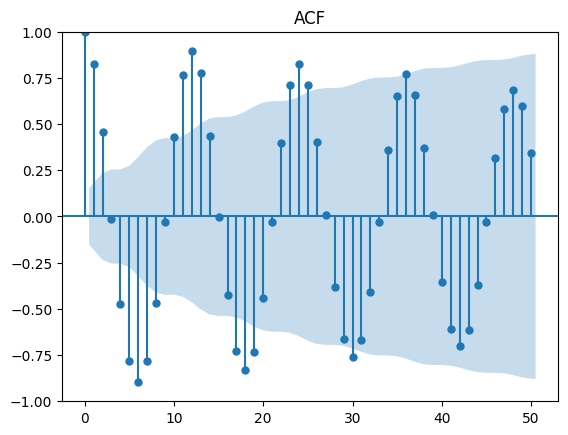

In [ ]:
# Graficamos los lags ACF, es decir, la correlación de la variable contra sí misma en otro momento del tiempo #
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt

smt.graphics.plot_acf(dfmundoSERIES, lags=50,title='ACF')
plt.show()

##### Grafico de los lags PACF

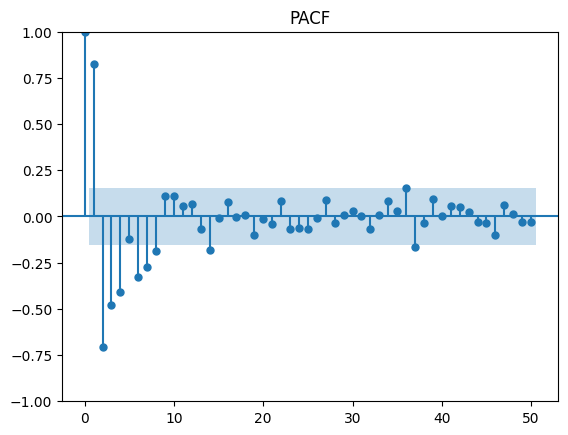

In [ ]:
# Objetivo: Resumen de la relación entre una observación en una serie temporal con las observaciones previas,
# eliminando la correlación con las observaciones intermedias
smt.graphics.plot_pacf(dfmundoSERIES, lags=50,title='PACF')
plt.show()

##### Test de hipotesis

Además de observar los lags para detectar tendencia, realizamos un test de hipótesis. Es un test donde la hipótesis nula $H_0$ indica que la serie no es estacionaria.
En otras palabras
- si p > 0.05 (nivel de significación mayor al 5%),  **$H_0$ no se rechaza**, y la serie *no es estacionaria*.
- Caso contrario, si p < 0.05, **la hipótesis nula se rechaza** y se considera *estacionaria*.


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(dfmundoSERIES);
print('ADF Statistic: %f' % result[0]); print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -4.024748
p-value: 0.001286
Valor crítico 1%: -3.47
Valor crítico 5%: -2.88
Valor crítico 10%: -2.58


### PASO 7: chequear estacionaridad

En el caso de China, la serie no es estacionaria por lo que hay que modificarla.

Como la serie no es estacionaria, d=1. ARIMA(p,d,q)

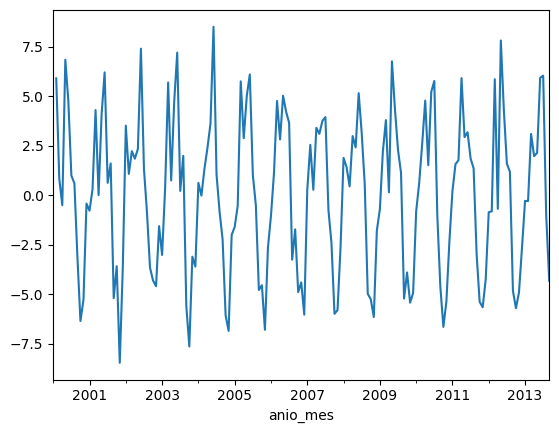

In [ ]:
dfmundoSERIESdif=dfmundoSERIES.diff()
dfmundoSERIESdif.plot();

##### Se cuentan la cantidad de lags significativos en ACF(q) Y PACF (p)

In [ ]:
!pip install pmdarima
d=0
from pmdarima import auto_arima
stepwise_fit = auto_arima(y, start_p=1, start_q=1,
                              max_p=12, max_q=12, m=12,
                              start_P=0, seasonal=False,
                              d=d, D=1, trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)
p, d, q = stepwise_fit.order
print(p,q)
predictions = []
order = (p,d,q)
model_ARIMA = ARIMA(dfmundoSERIES, order=order)
results_ARIMA = model_ARIMA.fit()
results_ARIMA.summary()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=440.775, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1518.117, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1304.420, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=442.829, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=423.144, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1118.905, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=424.419, Time=0.17 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=423.808, Time=0.23 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=425.181, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=377.108, Time=0.83 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=392.850, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=407.688, Time=0.34 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=367.243, T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     AverageTemperature   No. Observations:                  165
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -160.323
Date:                Thu, 30 Nov 2023   AIC                            334.647
Time:                        16:34:25   BIC                            356.388
Sample:                    01-01-2000   HQIC                           343.473
                         - 09-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.9189      0.044    547.986      0.000      23.833      24.004
ar.L1          0.7920      0.135      5.883      0.000       0.528       1.056
ar.L2          0.4709      0.208      2.267      0.023       0.064       0.878
ar.L3         -0.7239      0.110     -6.587      0.000      -0.939      -0.508
ma.L1         -0.1360      0.173     -0.786      0.432      -0.475       0.203
ma.L2         -0.4845      0.177     -2.735      0.006      -0.832      -0.137
sigma2         0.4027      0.047      8.481      0.000       0.310       0.496
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.47
Prob(Q):                              0.89   Prob(JB):                         0.48
Heteroskedasticity (H):               1.19   Skew:                             0.23
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### Se realiza la predicccion

In [ ]:
X = dfmundoSERIES.values
size = len(X) - 36
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

#Nos movemos de a un lag por vez y entrenamos el modelo sucesivas veces, a partir de la historia disponible
for t in range(len(test)):
	model = ARIMA(history, order=order)
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

#pyplot.plot(test)
#pyplot.plot(predictions, color='red')
#pyplot.show()

predicted=23.983927, expected=23.914000
predicted=24.674142, expected=24.310000
predicted=24.403112, expected=25.093333
predicted=25.108558, expected=25.154500
predicted=24.839708, expected=25.659833
predicted=24.894515, expected=24.514500
predicted=23.981071, expected=24.203833
predicted=23.311566, expected=22.481667
predicted=22.488883, expected=21.578833
predicted=21.706423, expected=21.933500
predicted=22.676899, expected=23.145667
predicted=23.937306, expected=23.230167
predicted=24.347008, expected=23.456167
predicted=24.262201, expected=23.231000
predicted=24.202687, expected=24.259167
predicted=24.688912, expected=24.235833
predicted=24.849944, expected=25.368667
predicted=25.127234, expected=25.038500
predicted=25.030657, expected=24.680667
predicted=24.091386, expected=22.693833
predicted=22.811791, expected=22.976500
predicted=22.656677, expected=22.316333
predicted=23.066522, expected=22.696667
predicted=23.073202, expected=24.095167
predicted=24.673598, expected=24.931000


In [ ]:
df_Results.loc[6, "Model"] = "Arima"
df_Results.loc[6, "RMSE"] = rmse
AIC = results_ARIMA.aic

df_Results.loc[6, "AIC"] = AIC
df_Results

,Model,RMSE,AIC
0,Random Walk,NaN,NaN
6,Arima,0.646712,334.646865
